# Importing Libraries and Creating Dataframes 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats


In [2]:
# Working Directory 
print(os.getcwd()) 
print(os.listdir(os.getcwd()))

# changing Directory --- os.chdir()

C:\Users\lalit
['.anaconda', '.bash_history', '.conda', '.condarc', '.config', '.gitconfig', '.ipynb_checkpoints', '.ipython', '.jupyter', '.matplotlib', '.QtWebEngineProcess', '.spyder-py3', '.Tableau', '.VirtualBox', '3D Objects', 'Anaconda3', 'AppData', 'Application Data', 'Contacts', 'Cookies', 'Desktop', 'Documents', 'Downloads', 'Favorites', 'git', 'hourly_irish_weather.csv', 'IntelGraphicsProfiles', 'Irish_weather_data_cork_new.csv', 'Links', 'Local Settings', 'MicrosoftEdgeBackups', 'Music', 'My Documents', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{8ebe95f7-3dcb-11e8-a9d9-7cfe90913f50}.TM.blf', 'NTUSER.DAT{8ebe95f7-3dcb-11e8-a9d9-7cfe90913f50}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{8ebe95f7-3dcb-11e8-a9d9-7cfe90913f50}.TMContainer00000000000000000002.regtrans-ms', 'ntuser.ini', 'OneDrive', 'PrintHood', 'Recent', 'Saved Games', 'Searches', 'SendTo', 'Start Menu', 'Templates', 'Thesis.ipynb', 'Videos', 'VirtualBox VMs', 'Zotero'

In [3]:
# reading csv files from local file system create dataframe Irish_weather_data

Irish_weather_data=pd.read_csv('hourly_irish_weather.csv',index_col = False)

# getting first 5 rows from dataaset 
Irish_weather_data.head()


,Unnamed: 0,date,station,county,longitude,latitude,rain,temp,wetb,dewpt,...,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt
0,0,1989-01-01 00:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.1,8.7,8.3,...,95.0,1036.3,13.0,190.0,10.0,22.0,0.0,10000.0,22.0,7.0
1,1,1989-01-01 01:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.0,8.7,8.4,...,96.0,1036.2,13.0,190.0,10.0,22.0,0.0,8000.0,4.0,8.0
2,2,1989-01-01 02:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,8.9,8.5,8.1,...,95.0,1036.0,12.0,190.0,10.0,22.0,0.0,8000.0,4.0,8.0
3,3,1989-01-01 03:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.0,8.7,8.4,...,96.0,1035.9,11.0,190.0,10.0,22.0,0.0,8000.0,4.0,8.0
4,4,1989-01-01 04:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.0,8.6,8.2,...,95.0,1035.8,10.0,190.0,10.0,22.0,0.0,10000.0,14.0,8.0


In [4]:
# Filter Data for county Cork and create new datframe with name cork 

Irish_weather_data_cork = Irish_weather_data[Irish_weather_data.county == 'Cork']

# Displaying sample data first 5 rows
Irish_weather_data_cork.head()

,Unnamed: 0,date,station,county,longitude,latitude,rain,temp,wetb,dewpt,...,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt
0,0,1989-01-01 00:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.1,8.7,8.3,...,95.0,1036.3,13.0,190.0,10.0,22.0,0.0,10000.0,22.0,7.0
1,1,1989-01-01 01:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.0,8.7,8.4,...,96.0,1036.2,13.0,190.0,10.0,22.0,0.0,8000.0,4.0,8.0
2,2,1989-01-01 02:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,8.9,8.5,8.1,...,95.0,1036.0,12.0,190.0,10.0,22.0,0.0,8000.0,4.0,8.0
3,3,1989-01-01 03:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.0,8.7,8.4,...,96.0,1035.9,11.0,190.0,10.0,22.0,0.0,8000.0,4.0,8.0
4,4,1989-01-01 04:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.0,8.6,8.2,...,95.0,1035.8,10.0,190.0,10.0,22.0,0.0,10000.0,14.0,8.0


In [5]:

# Creating Dataframe with required column (Temp,Wetb,Dewpt,vappr)
Irish_weather_data_cork_filt = Irish_weather_data_cork[['date','station','county','longitude','latitude','temp','wetb','dewpt','vappr']].copy()

# Displaying first 5 rows from datframe Irish_weather_data_cork_new

Irish_weather_data_cork_filt.head()


,date,station,county,longitude,latitude,temp,wetb,dewpt,vappr
0,1989-01-01 00:00:00,Cork_Airport,Cork,-8.485,51.842,9.1,8.7,8.3,10.9
1,1989-01-01 01:00:00,Cork_Airport,Cork,-8.485,51.842,9.0,8.7,8.4,11.0
2,1989-01-01 02:00:00,Cork_Airport,Cork,-8.485,51.842,8.9,8.5,8.1,10.8
3,1989-01-01 03:00:00,Cork_Airport,Cork,-8.485,51.842,9.0,8.7,8.4,11.0
4,1989-01-01 04:00:00,Cork_Airport,Cork,-8.485,51.842,9.0,8.6,8.2,10.8


# 1. Exploratory Data Analysis 

In [6]:
# ROW and colummn count
Irish_weather_data_cork.shape


(735357, 21)

In [8]:
Irish_weather_data_cork_filt['station'] = Irish_weather_data_cork_filt['station'].astype('str')
Irish_weather_data_cork_filt['county'] = Irish_weather_data_cork_filt['county'].astype('str')
Irish_weather_data_cork_filt['date'] = Irish_weather_data_cork_filt['date'].astype('str')

# Irish_weather_data_cork_new['date'] = pd.to_datetime(Irish_weather_data_cork_new['date'])


# Displaying Dataframe Information 
Irish_weather_data_cork_filt.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 735357 entries, 0 to 735356
Data columns (total 9 columns):
date         735357 non-null object
station      735357 non-null object
county       735357 non-null object
longitude    735357 non-null float64
latitude     735357 non-null float64
temp         714410 non-null float64
wetb         706510 non-null float64
dewpt        706557 non-null float64
vappr        683446 non-null float64
dtypes: float64(6), object(3)
memory usage: 56.1+ MB


 # 1.1 Identify and Plotting  Null Values

In [9]:
# checking for null value in Dataframe 
Irish_weather_data_cork_filt.isnull().values.any()

True

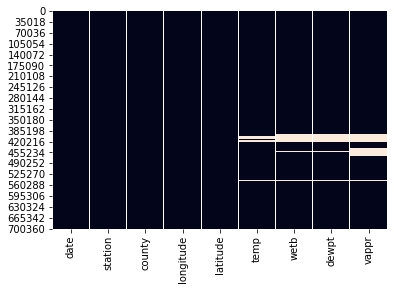

In [10]:
# displaying null values on heatmap 
sns.heatmap(Irish_weather_data_cork_filt.isnull(), cbar=False)

In [12]:
# Creating Dataframe with null values to see year wise null value counting 
Irish_weather_data_cork_null = Irish_weather_data_cork_filt[Irish_weather_data_cork_filt.isna().any(axis=1)]

# plotting 1st 5 rows from dataframe 
Irish_weather_data_cork_null.head()


,date,station,county,longitude,latitude,temp,wetb,dewpt,vappr
158225,2007-01-19 17:00:00,Cork_Airport,Cork,-8.485,51.842,11.2,11.6,11.1,NaN
181068,2009-08-28 12:00:00,Cork_Airport,Cork,-8.485,51.842,15.0,NaN,8.8,11.3
181069,2009-08-28 13:00:00,Cork_Airport,Cork,-8.485,51.842,13.4,NaN,9.9,12.2
181070,2009-08-28 14:00:00,Cork_Airport,Cork,-8.485,51.842,14.8,NaN,7.8,10.6
181071,2009-08-28 15:00:00,Cork_Airport,Cork,-8.485,51.842,14.0,NaN,8.4,11.1


In [14]:
# splitting date column into three column Year,month, day and Hrs

Irish_weather_data_cork_null[['year','month','day']] = Irish_weather_data_cork_null.date.str.split("-",expand=True,)
Irish_weather_data_cork_null[['day','Hrs']] = Irish_weather_data_cork_null.day.str.split(" ",expand=True,)

In [15]:
Irish_weather_data_cork_null.head()

,date,station,county,longitude,latitude,temp,wetb,dewpt,vappr,year,month,day,Hrs
158225,2007-01-19 17:00:00,Cork_Airport,Cork,-8.485,51.842,11.2,11.6,11.1,NaN,2007,01,19,17:00:00
181068,2009-08-28 12:00:00,Cork_Airport,Cork,-8.485,51.842,15.0,NaN,8.8,11.3,2009,08,28,12:00:00
181069,2009-08-28 13:00:00,Cork_Airport,Cork,-8.485,51.842,13.4,NaN,9.9,12.2,2009,08,28,13:00:00
181070,2009-08-28 14:00:00,Cork_Airport,Cork,-8.485,51.842,14.8,NaN,7.8,10.6,2009,08,28,14:00:00
181071,2009-08-28 15:00:00,Cork_Airport,Cork,-8.485,51.842,14.0,NaN,8.4,11.1,2009,08,28,15:00:00


In [16]:
# Displaying null values for each year 
Irish_weather_data_cork_null.year.value_counts()

1994    8736
2000    8570
1993    8015
1995    7727
1999    7606
1998    5552
2001    1485
1996    1467
2003    1139
2004     708
2005     188
2006     172
2008     163
2007      97
1997      89
2002      62
2017      57
2010      29
2011      28
2009      22
2012      21
2014      11
2015      10
2013       4
Name: year, dtype: int64

## 1.2 

## Creating Dataframe with Null and without Null and  counting rows 
## Identifying duplicated value in clean(Without null) dataframe 

In [17]:

# Calculating clean dataframe without null values 
Irish_weather_data_cork_withoutnull = Irish_weather_data_cork_filt.dropna(axis = 0, how ='any')

# Displaying dataframe count with and without null values 

print("Old data frame length:", len(Irish_weather_data_cork_filt), "\nNew data frame length:",  
       len(Irish_weather_data_cork_withoutnull), "\nNumber of rows with at least 1 NA value: ", 
       (len(Irish_weather_data_cork_filt)-len(Irish_weather_data_cork_withoutnull))) 


Old data frame length: 735357 
New data frame length: 683399 
Number of rows with at least 1 NA value:  51958


In [18]:

# Finding Duuplicate values from Dataframe
Irish_weather_data_cork_withoutnull.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
735352    False
735353    False
735354    False
735355    False
735356    False
Length: 683399, dtype: bool

In [19]:
# Displaying duplicate rows from dataframe 
Irish_weather_data_cork_withoutnull[Irish_weather_data_cork_withoutnull.duplicated(keep=False)]

,date,station,county,longitude,latitude,temp,wetb,dewpt,vappr


## 1.3 Correlation Plot 

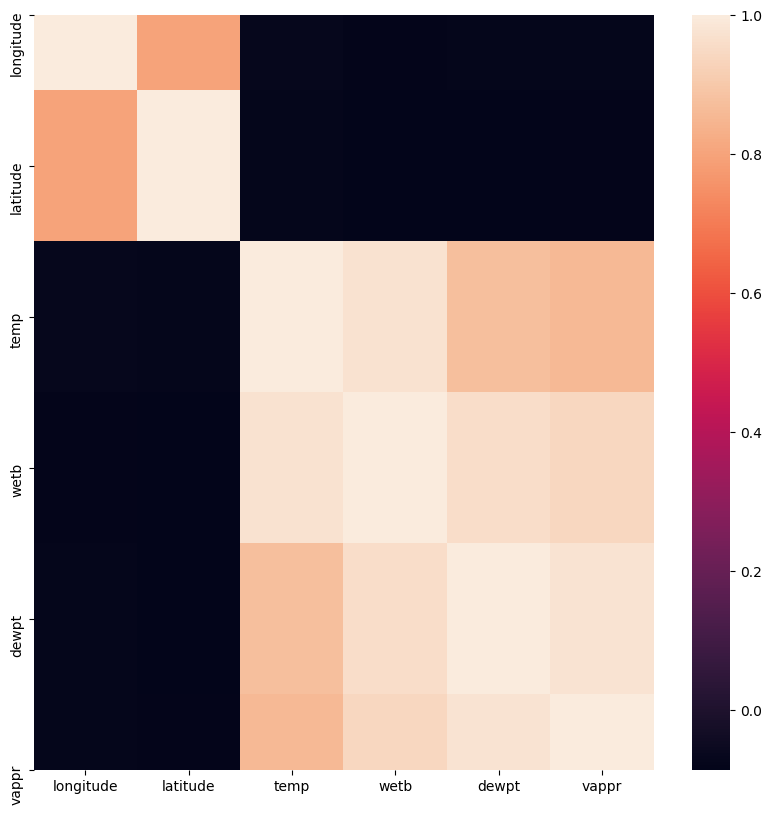

In [20]:

# Corelation plot of dataframe 

plt.figure(figsize= (10,10), dpi=100)
sns.heatmap(Irish_weather_data_cork_withoutnull.corr())

## 1.4 Outlier Detection and Removal using IQR method

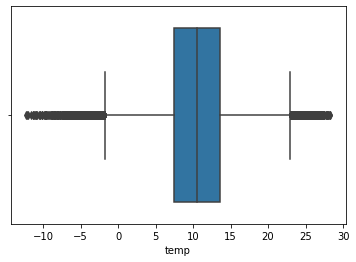

In [21]:
sns.boxplot(x=Irish_weather_data_cork_withoutnull['temp'])

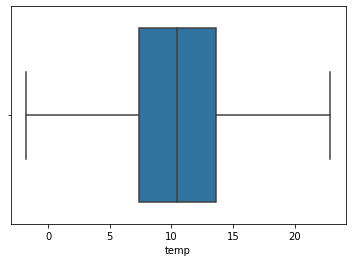

In [22]:
Q1 = Irish_weather_data_cork_withoutnull['temp'].quantile(0.25)
Q3 = Irish_weather_data_cork_withoutnull['temp'].quantile(0.75)
IQR = Q3 - Q1

filter = (Irish_weather_data_cork_withoutnull['temp'] >= Q1 - 1.5 * IQR) & (Irish_weather_data_cork_withoutnull['temp'] <= Q3 + 1.5 *IQR)


Irish_weather_data_cork_withoutnull= Irish_weather_data_cork_withoutnull.loc[filter] 
Irish_weather_data_cork_withoutnull.head()
sns.boxplot(x=Irish_weather_data_cork_withoutnull['temp'])

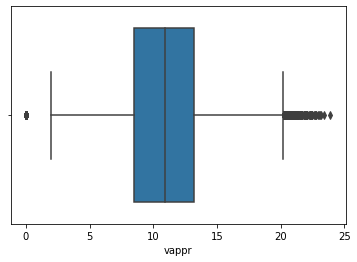

In [23]:
sns.boxplot(x=Irish_weather_data_cork_withoutnull['vappr'])

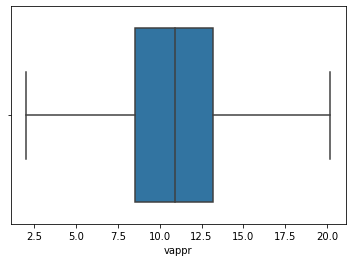

In [24]:
Q1 = Irish_weather_data_cork_withoutnull['vappr'].quantile(0.25)
Q3 = Irish_weather_data_cork_withoutnull['vappr'].quantile(0.75)
IQR = Q3 - Q1

filter = (Irish_weather_data_cork_withoutnull['vappr'] >= Q1 - 1.5 * IQR) & (Irish_weather_data_cork_withoutnull['vappr'] <= Q3 + 1.5 *IQR)


Irish_weather_data_cork_withoutnull= Irish_weather_data_cork_withoutnull.loc[filter] 
Irish_weather_data_cork_withoutnull.head()
sns.boxplot(x=Irish_weather_data_cork_withoutnull['vappr'])

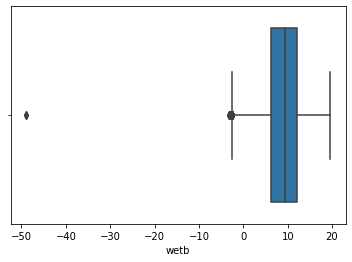

In [25]:
sns.boxplot(x=Irish_weather_data_cork_withoutnull['wetb'])

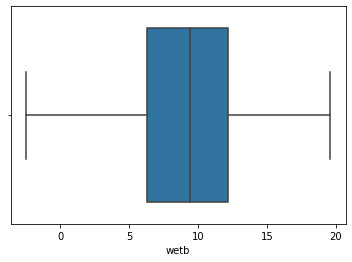

In [26]:
Q1 = Irish_weather_data_cork_withoutnull['wetb'].quantile(0.25)
Q3 = Irish_weather_data_cork_withoutnull['wetb'].quantile(0.75)
IQR = Q3 - Q1

filter = (Irish_weather_data_cork_withoutnull['wetb'] >= Q1 - 1.5 * IQR) & (Irish_weather_data_cork_withoutnull['wetb'] <= Q3 + 1.5 *IQR)


Irish_weather_data_cork_withoutnull= Irish_weather_data_cork_withoutnull.loc[filter] 
sns.boxplot(x=Irish_weather_data_cork_withoutnull['wetb'])

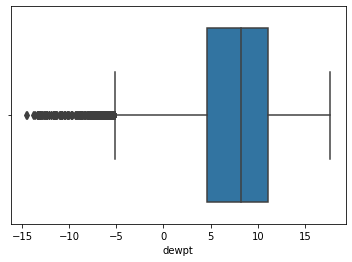

In [27]:
sns.boxplot(x=Irish_weather_data_cork_withoutnull['dewpt'])

In [28]:
Q1 = Irish_weather_data_cork_withoutnull['dewpt'].quantile(0.25)
Q3 = Irish_weather_data_cork_withoutnull['dewpt'].quantile(0.75)
IQR = Q3 - Q1

filter = (Irish_weather_data_cork_withoutnull['dewpt'] >= Q1 - 1.5 * IQR) & (Irish_weather_data_cork_withoutnull['dewpt'] <= Q3 + 1.5 *IQR)


Irish_weather_data_cork_withoutnull= Irish_weather_data_cork_withoutnull.loc[filter]

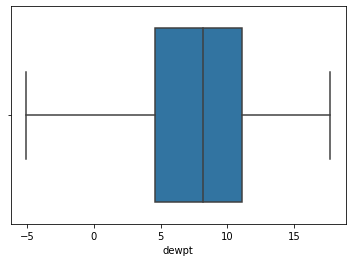

In [29]:
sns.boxplot(x=Irish_weather_data_cork_withoutnull['dewpt'])

In [30]:
Irish_weather_data_cork_withoutnull.head()

,date,station,county,longitude,latitude,temp,wetb,dewpt,vappr
0,1989-01-01 00:00:00,Cork_Airport,Cork,-8.485,51.842,9.1,8.7,8.3,10.9
1,1989-01-01 01:00:00,Cork_Airport,Cork,-8.485,51.842,9.0,8.7,8.4,11.0
2,1989-01-01 02:00:00,Cork_Airport,Cork,-8.485,51.842,8.9,8.5,8.1,10.8
3,1989-01-01 03:00:00,Cork_Airport,Cork,-8.485,51.842,9.0,8.7,8.4,11.0
4,1989-01-01 04:00:00,Cork_Airport,Cork,-8.485,51.842,9.0,8.6,8.2,10.8
